In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from catboost import CatBoostRegressor
from pycaret.regression import *

## Load data

# DataSet 다운로드
### https://www.kaggle.com/datasets/mirichoi0218/insurance
### About Dataset
Context
Machine Learning with R by Brett Lantz is a book that provides an introduction to machine learning using R. As far as I can tell, Packt Publishing does not make its datasets available online unless you buy the book and create a user account which can be a problem if you are checking the book out from the library or borrowing the book from a friend. All of these datasets are in the public domain but simply needed some cleaning up and recoding to match the format in the book.

Content
Columns

age: age of primary beneficiary

sex: insurance contractor gender, female, male

bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

children: Number of children covered by health insurance / Number of dependents

smoker: Smoking

region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

charges: Individual medical costs billed by health insurance

In [2]:
data = pd.read_csv("./insurance.csv")

In [3]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Data info

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
data.shape

(1338, 7)

In [7]:
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [8]:
# 중복데이터 삭제
print(data.duplicated().sum())
data.drop_duplicates(inplace=True)
print(data.duplicated().sum())

1
0


## EDA & Data Visualization

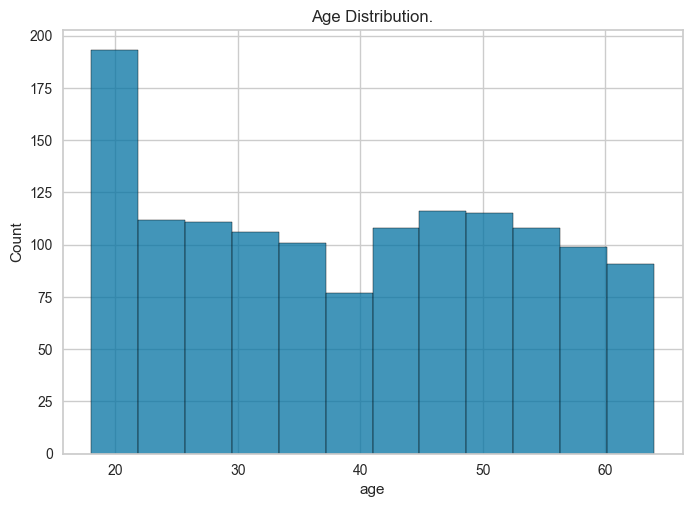

In [9]:
sns.histplot(data, x="age")
plt.title("Age Distribution.")
plt.show()

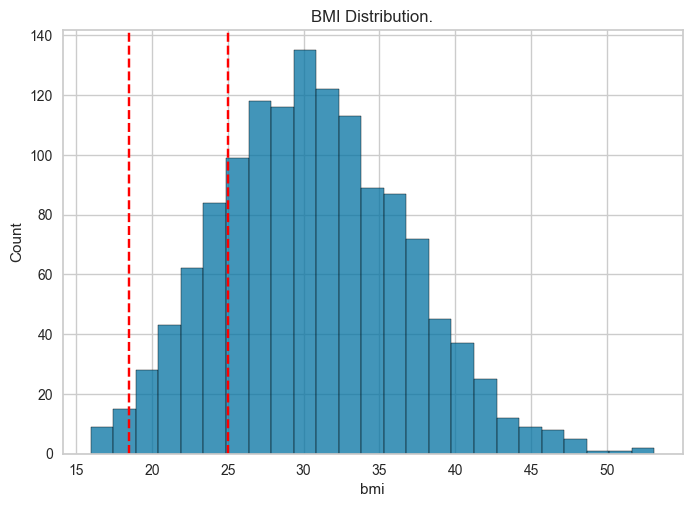

In [10]:
# 정상범위를 18.5 ~ 25로 간주
sns.histplot(data=data, x="bmi")
plt.title("BMI Distribution.")
plt.axvline(18.5, color="red", linestyle='--')
plt.axvline(25, color="red", linestyle='--')
plt.show()

In [11]:
normal = ((data['bmi'] >= 18.5) & (data['bmi'] <= 25)).mean()

print(f"전체 인구 중 정상체중인 인원의 비율 : {np.round(normal, 4) * 100}%")

전체 인구 중 정상체중인 인원의 비율 : 16.98%


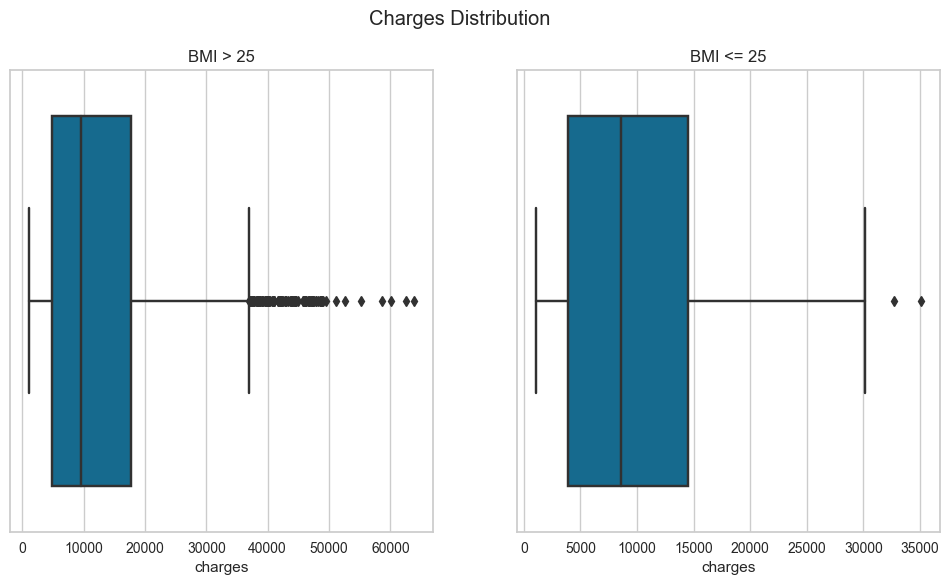

In [12]:
# BMI가 25 초과,이하인 두 그룹으로 나눠 보험료 비교
data_over25 = data[data['bmi'] > 25]
data_under25 = data[data['bmi'] <= 25]

fig, axis = plt.subplots(1, 2, figsize=(12,6))
sns.boxplot(data_over25, x="charges", ax=axis[0])
axis[0].set_title("BMI > 25")
sns.boxplot(data_under25, x="charges", ax=axis[1])
axis[1].set_title("BMI <= 25")
fig.suptitle("charges Distribution".title())
plt.show()

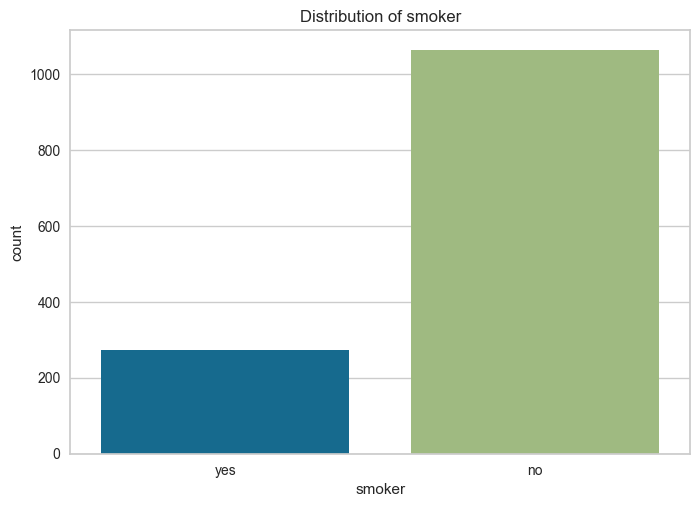

In [13]:
# 흡연자 수 확인
sns.countplot(data=data, x="smoker")
plt.title("Distribution of smoker")
plt.show()

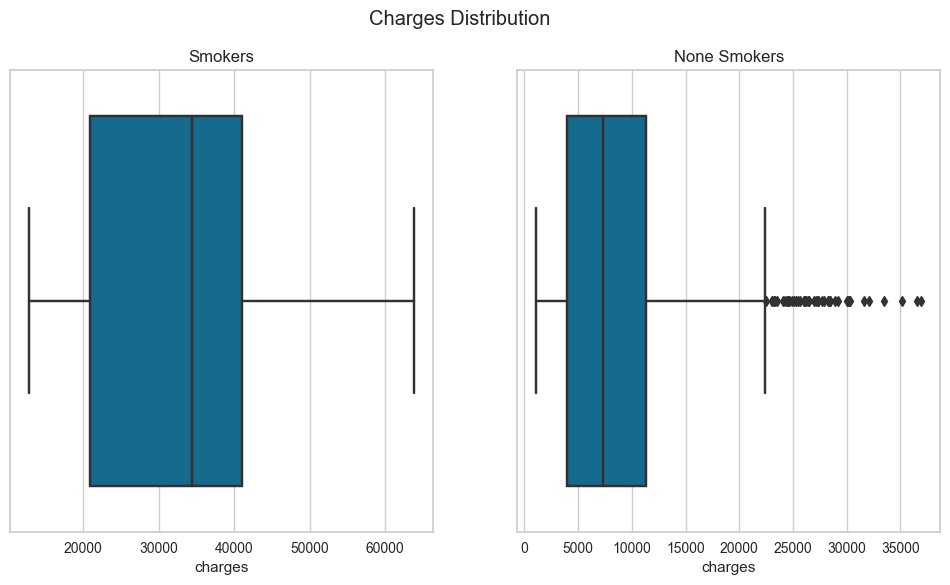

In [14]:
# 흡연자와 비흡연자의 보험료 비교
data_smoker = data[data['smoker'] == "yes"]
data_none_smoker = data[data['smoker'] == "no"]

fig, axis = plt.subplots(1, 2, figsize=(12,6))
sns.boxplot(data_smoker, x="charges", ax=axis[0])
axis[0].set_title("Smokers")
sns.boxplot(data_none_smoker, x="charges", ax=axis[1])
axis[1].set_title("None Smokers")
fig.suptitle("charges Distribution".title())
plt.show()

<Axes: >

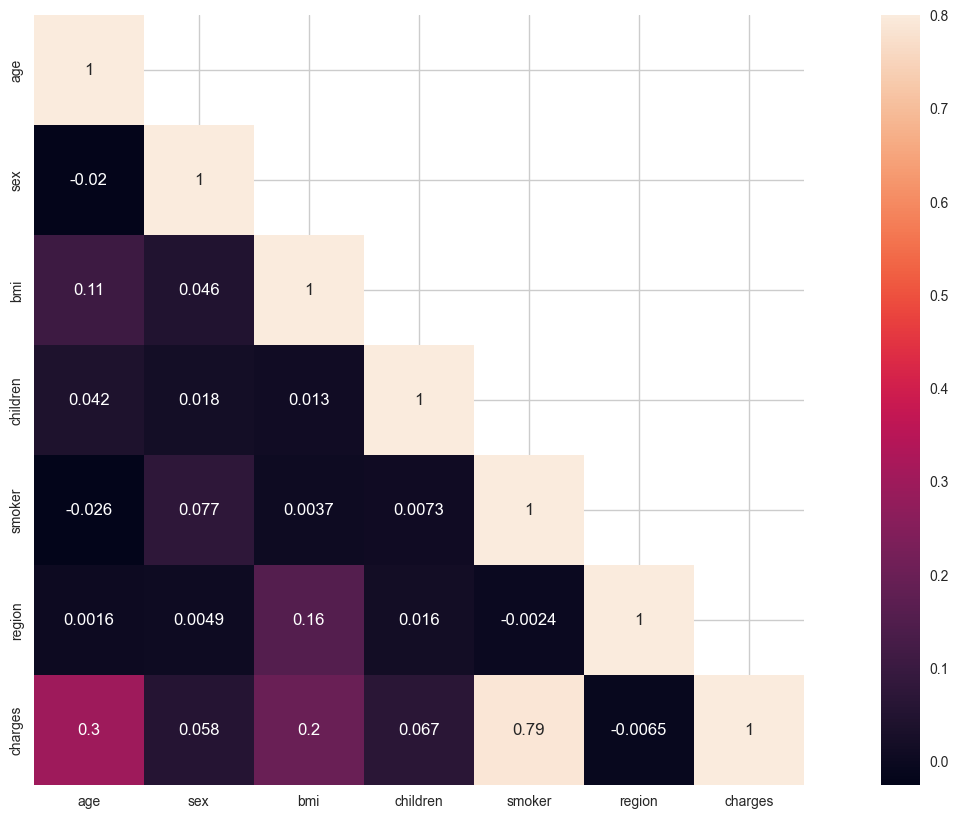

In [15]:
label_encoder = LabelEncoder()
object_columns = ['sex', 'smoker', 'region']
data_corr = data.copy()
for column in object_columns:
    data_corr[column] = label_encoder.fit_transform(data_corr[column])

# Heatmap을 통한 상관관계 확인
corrMatt = data_corr.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)]=False

fig,ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8,square= True, annot=True)

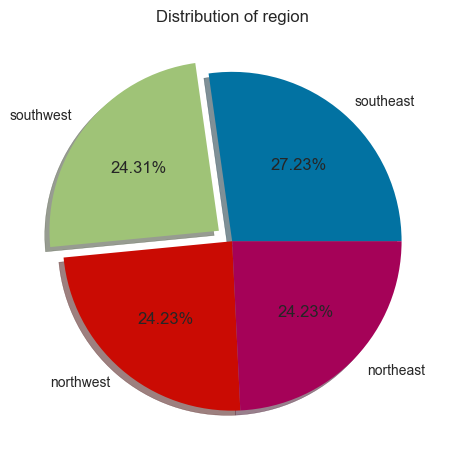

In [16]:
# 지역별 인구 수 확인
region_count = data["region"].value_counts()
plt.pie(labels=region_count.index,
        x=region_count.values,
        shadow=True,
        autopct = '%.2f%%',
        explode = (0, 0.1, 0, 0))
plt.title("Distribution of region")
plt.show()

## Custom Trasnformer

In [17]:
# 사용자 정의 Transformer
# Age를 Bmi로 나눈 치수로 새로운 Column 생성
class CustomBMIClassifier(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['age_mul_bmi'] = X['age'] * X['bmi']
        
        return X

## Create Pipeline

In [18]:
# 숫자형 특성과 범주형 특성 구분
numeric_features = ['age', 'bmi', 'age_mul_bmi']
categorical_features = ['sex', 'children', 'smoker', 'region']

In [19]:
# 파이프라인 정의
numeric_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

custom_bmi_classifier = CustomBMIClassifier()

# 최종 파이프라인
pipeline = Pipeline(steps=[('custom', custom_bmi_classifier), ('preprocessor', preprocessor)])

## Train Test split

In [20]:
X = data.drop(columns=["charges"], axis=1)
y = data["charges"]

In [21]:
# 데이터 변환
X_transformed = pipeline.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size= 0.2, random_state= 42, shuffle=True)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# 데이터 Shape 확인
print(f"the shape of X train: {X_train.shape}")
print(f"the shape of y train: {y_train.shape}")

print("*"*30)

print(f"the shape of X test: {X_test.shape}")
print(f"the shape of y test: {y_test.shape}")

the shape of X train: (1069, 20)
the shape of y train: (1069,)
******************************
the shape of X test: (268, 20)
the shape of y test: (268,)


## 새로운 컬럼 상관관계 확인

In [22]:
X["charges"] = y

<Axes: >

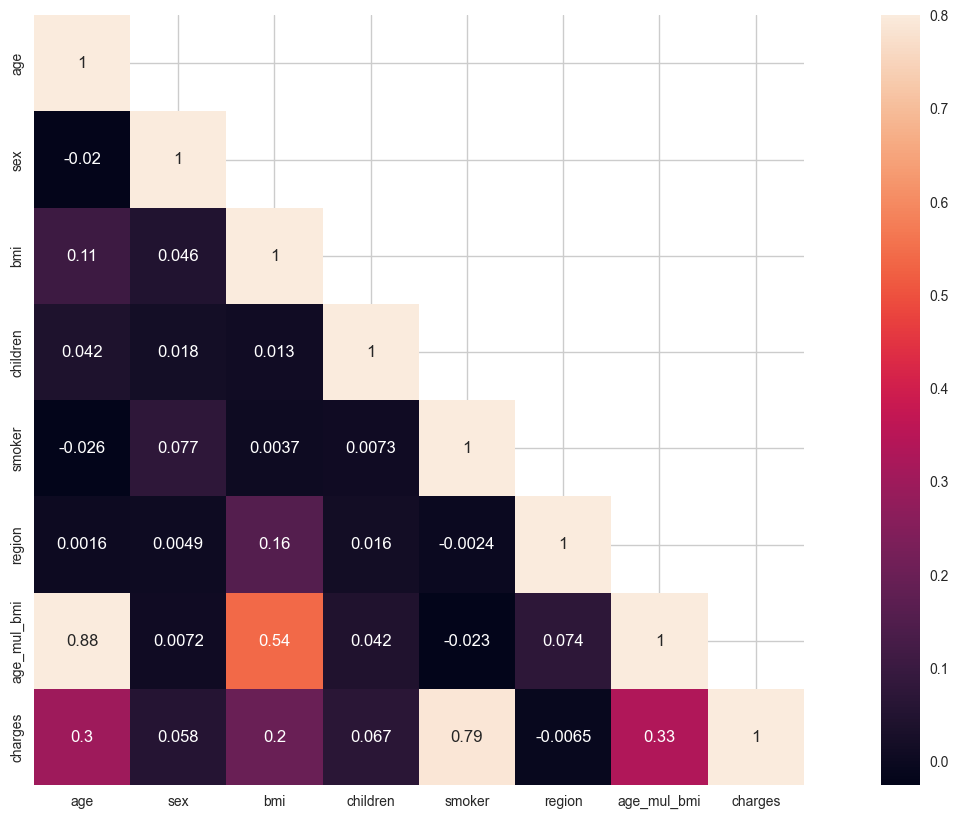

In [23]:
label_encoder = LabelEncoder()
object_columns = ['sex', 'smoker', 'region']
data_corr = X.copy()
for column in object_columns:
    data_corr[column] = label_encoder.fit_transform(data_corr[column])

# Heatmap을 통한 상관관계 확인
corrMatt = data_corr.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)]=False

fig,ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8,square= True, annot=True)

## Pycaret

In [24]:
reg = setup(data,target='charges',train_size=0.8)

,Description,Value
0,Session id,5292
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1337, 7)"
4,Transformed data shape,"(1337, 10)"
5,Transformed train set shape,"(1069, 10)"
6,Transformed test set shape,"(268, 10)"
7,Ordinal features,2
8,Numeric features,3
9,Categorical features,3


In [25]:
best=compare_models(sort='rmse')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2508.2176,21334686.7328,4538.8554,0.8499,0.4222,0.2895,0.0200
catboost,CatBoost Regressor,2648.7555,22594697.8970,4671.8808,0.8416,0.4551,0.3149,0.2230
lightgbm,Light Gradient Boosting Machine,2789.7939,22941487.8081,4705.7057,0.8401,0.5181,0.3491,0.0940
rf,Random Forest Regressor,2683.0113,23424795.4081,4771.2758,0.8352,0.4630,0.3219,0.0450
et,Extra Trees Regressor,2665.7153,26258621.3876,5057.6015,0.8145,0.4769,0.3183,0.0370
xgboost,Extreme Gradient Boosting,2989.0450,26655804.1000,5095.5532,0.8118,0.5388,0.3776,0.0550
ada,AdaBoost Regressor,4313.4742,28084037.9364,5278.0534,0.8000,0.6493,0.7657,0.0140
llar,Lasso Least Angle Regression,4193.7809,37168764.5238,6059.9941,0.7384,0.5901,0.4238,0.0110
lasso,Lasso Regression,4193.7806,37168766.1838,6059.9942,0.7384,0.5901,0.4238,0.3850
br,Bayesian Ridge,4199.2041,37171030.0882,6060.0270,0.7385,0.5932,0.4248,0.0110


##  회귀 모델 학습 및 결과 확인

In [26]:
model_GBR = GradientBoostingRegressor(n_estimators=100, learning_rate=0.09, max_depth=3, random_state=42)
model_RFR = RandomForestRegressor(n_estimators=100, random_state=42)
model_CBR = CatBoostRegressor(iterations=1000,
                                 learning_rate=0.1,
                                 depth=4,
                                 l2_leaf_reg=20,
                                 bootstrap_type='Bernoulli',
                                 subsample=0.6,
                                 eval_metric='RMSE',
                                 metric_period=50,
                                 od_type='Iter',
                                 od_wait=45,
                                 random_seed=42,
                                 allow_writing_files=False,
                                 verbose=0)

In [27]:
model_GBR.fit(X_train, y_train)
model_RFR.fit(X_train, y_train)
model_CBR.fit(X_train, y_train, early_stopping_rounds=20)

In [28]:
GBR_pred = model_GBR.predict(X_test)
RFR_pred = model_RFR.predict(X_test)
CBR_pred = model_CBR.predict(X_test)

In [29]:
GBR_rmse = np.sqrt(mean_squared_error(y_test, GBR_pred))
RFR_rmse = np.sqrt(mean_squared_error(y_test, RFR_pred))
CBR_rmse = np.sqrt(mean_squared_error(y_test, CBR_pred))

print(f"GBR Root Mean Squared Error (RMSE): {np.round(GBR_rmse, 4)}")
print("*" * 20)
print(f"RFR Root Mean Squared Error (RMSE): {np.round(RFR_rmse, 4)}")
print("*" * 20)
print(f"CBR Root Mean Squared Error (RMSE): {np.round(CBR_rmse, 4)}")

GBR Root Mean Squared Error (RMSE): 4282.72
********************
RFR Root Mean Squared Error (RMSE): 4598.8106
********************
CBR Root Mean Squared Error (RMSE): 4599.6287


In [30]:
GBR_r2 = r2_score(y_test, GBR_pred)
RFR_r2 = r2_score(y_test, RFR_pred)
CBR_r2 = r2_score(y_test, CBR_pred)

print(f"GBR R2 Score: {np.round(GBR_r2, 3) * 100}%")
print("*" * 20)
print(f"RFR R2 Score: {np.round(RFR_r2, 3) * 100}%")
print("*" * 20)
print(f"CBR R2 Score: {np.round(CBR_r2, 3) * 100}%")

GBR R2 Score: 90.0%
********************
RFR R2 Score: 88.5%
********************
CBR R2 Score: 88.5%


## 학습 그래프 시각화

In [31]:
def plot_learning_curve(train_sizes, train_scores, test_scores, model_name):
    
    # 평균 및 표준 편차 계산
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # 학습 곡선 그리기.
    plt.figure()
    plt.title(f"{model_name} Learning Curve")
    plt.xlabel("Training Batch")
    plt.ylabel("Score")
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation Score")
    
    plt.legend(loc="best")
    plt.show()

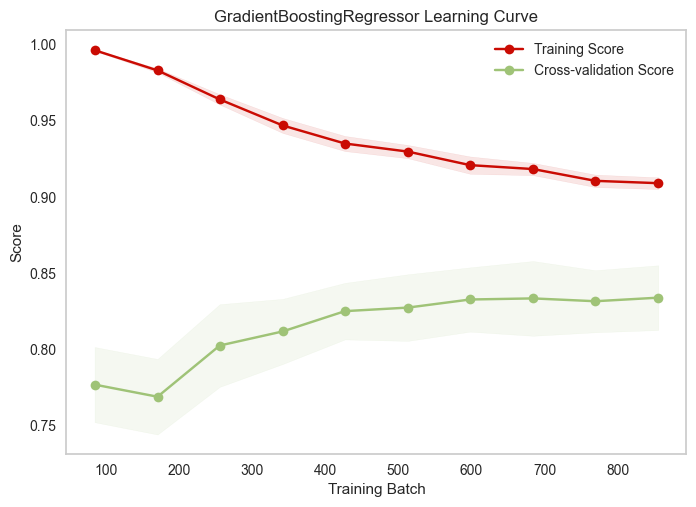

In [32]:
# GradientBoostingRegressor 모델 학습 그래프
train_sizes, train_scores, test_scores = learning_curve(model_GBR, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

plot_learning_curve(train_sizes, train_scores, test_scores, "GradientBoostingRegressor")

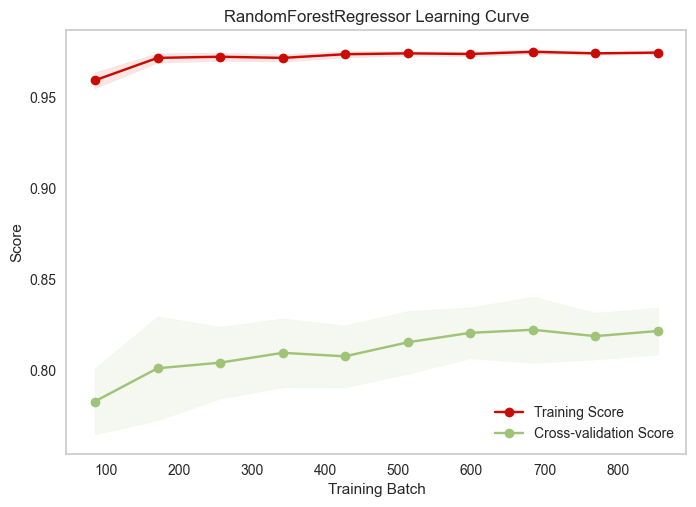

In [33]:
# RandomForestRegressor 모델 학습 그래프
train_sizes, train_scores, test_scores = learning_curve(model_RFR, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

plot_learning_curve(train_sizes, train_scores, test_scores, "RandomForestRegressor")

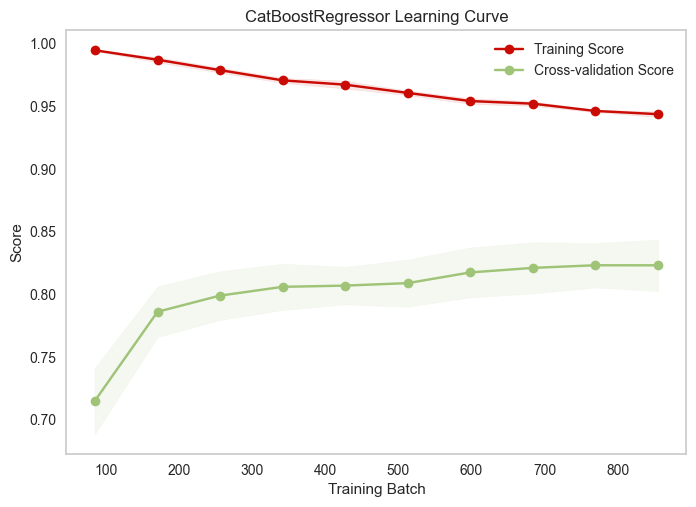

In [34]:
# CatBoostRegressor 모델 학습 그래프
train_sizes, train_scores, test_scores = learning_curve(model_CBR, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

plot_learning_curve(train_sizes, train_scores, test_scores, "CatBoostRegressor")

## Feature Importance

In [35]:
# Feature Importance 시각화
def plot_feature_importance(importance, model_name):
    features = range(len(importance))
    plt.figure(figsize=(10, 6))
    plt.barh(features, importance, align='center')
    plt.yticks(features, [f'Feature {i}' for i in features])
    plt.xlabel('Feature Importance')
    plt.title(f'{model_name} Feature Importance')
    plt.show()

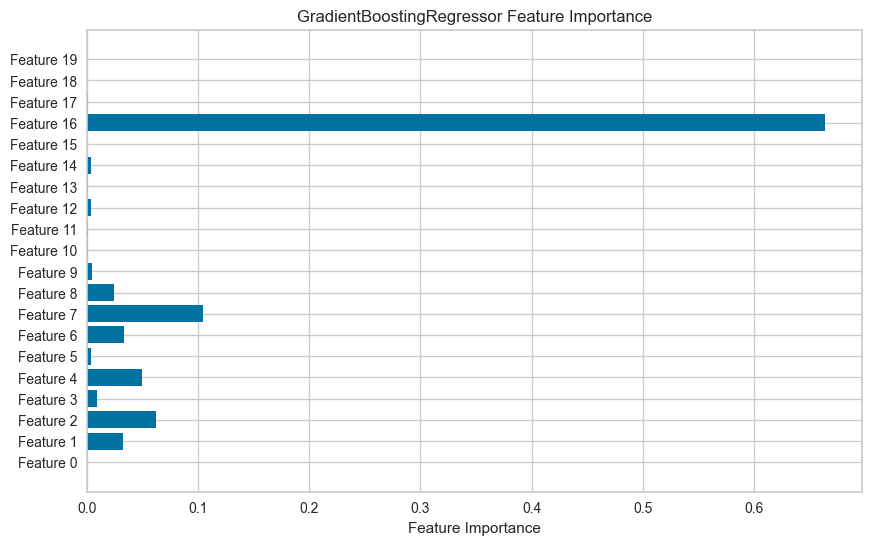

In [36]:
# GradientBoostingRegressor Feature Importance
gbr_importance = model_GBR.feature_importances_
plot_feature_importance(gbr_importance, 'GradientBoostingRegressor')

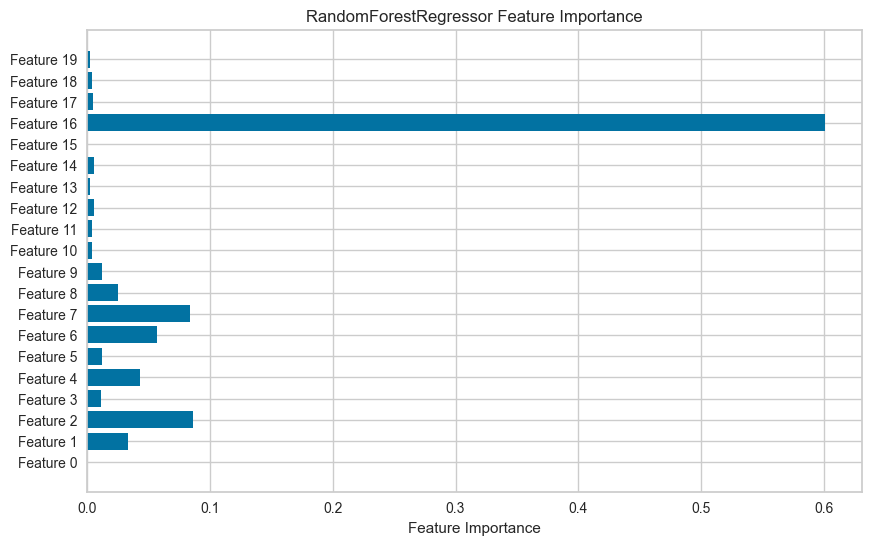

In [37]:
# RandomForestRegressor Feature Importance
rfr_importance = model_RFR.feature_importances_
plot_feature_importance(rfr_importance, 'RandomForestRegressor')

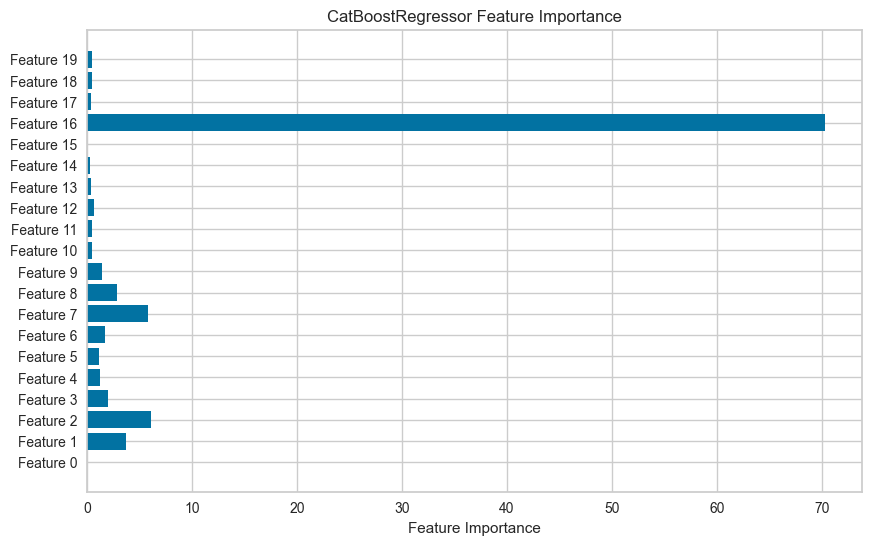

In [38]:
# CatBoostRegressor Feature Importance
catboost_importance = model_CBR.get_feature_importance()
plot_feature_importance(catboost_importance, 'CatBoostRegressor')